# 6.semantic_network

In this notebook, we create the different bipartite semantic networks on the subset of Bushfire tweets included in section 6 of our exam. We define actor nodes as being either Party or MP and document nodes as being either hashtags or words (unigrams and bigrams). To do this, we use the Textnets package. Documentation can be found here https://textnets.readthedocs.io/en/stable/ and our implementation is also inspired by the example here: https://www.jboy.space/blog/enemies-foreign-and-partisan.html. 

In [1]:
#Necessary imports
import pandas as pd
from textnets import Corpus, Textnet
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
import igraph as ig

## Preparing the Network

In [2]:
network_df = pd.read_csv("data/bushfire_subset.csv", index_col=0)

#Process the list of hashtags
network_df["hashtags"] = network_df["hashtags"].apply(eval).apply(' '.join)
network_df["hashtags"] = network_df["hashtags"].str.split()
#Dummy variable for if tweet has hashtag
network_df["hashashtag"] = network_df["hashtags"].apply(lambda x: 1 if len(x) > 0 else 0)

#Remove katters
network_df = network_df.loc[network_df["party"] != "Katter's Australian Party"]

#Explode the data set on hashtags if a tweet has several
hashtag_df = network_df.loc[network_df["hashashtag"] == 1].reset_index(drop = True)
hashtag_df = hashtag_df.explode("hashtags")
hashtag_df["party2"] = hashtag_df["party"]

#Get hashtags used more than once
hashtags = hashtag_df["hashtags"].tolist()
hashtags = [w[0] for w in Counter(hashtags).items() if w[1] >= 2]
hashtag_df["top_hashtags"] = hashtag_df["hashtags"].apply(lambda x: x if x in hashtags else np.nan)

In [3]:
#Helper functions for creating network corpus
def create_network(df, actor, doc_col, min_docs = 1, node_type = None):
    if doc_col == "top_hashtags":
        df = df.dropna(subset = ["top_hashtags"])
    #Set index to actor
    df = df.set_index(actor)
    corpus = Corpus.from_df(df, doc_col=doc_col, lang='en')
    tn = Textnet(corpus.tokenized(stem = False, lower=False, remove_punctuation = False,
                                 remove_numbers = False, remove_stop_words = False,
                                 remove_urls = False), min_docs=min_docs, 
                                 doc_attrs=df[['party']].to_dict())
    
    if node_type:
        tn = tn.project(node_type=node_type)
    
    return tn

#Helper functions for plotting network
def plot_network(tn, label_size = 6, scale_by = "degree"):
    plot = tn.plot(label_term_nodes=True,
                   label_doc_nodes=True,
                   label_nodes=True,
                    scale_nodes_by = scale_by,
                    vertex_label_size = label_size,
                    vertex_color=['gray' if v['party'] is None 
                                  else ('dodgerblue' if v['party'] == 'Liberal Party of Australia'
                                  else ('indianred' if v['party'] == 'Australian Labor Party' 
                                  else ('lightgreen' if v['party'] == 'Australian Greens' 
                                  else ('gold' if v['party'] == 'The Nationals' 
                                  else ('darkorange' if v['party'] == 'Center Alliance' 
                                  else ('pink' if v['party'] == 'Liberal National Party of Queensland'
                                  else  'purple'))))))
                                  for v in tn.vs],
                    vertex_shape=['none' if v['party'] is None 
                                  else 'triangle' if v['party'] == 'Liberal Party of Australia'
                                  else 'triangle-down'
                                  for v in tn.vs],
                  dpi = 1000,
                  format = "pdf")
    
    return plot

## Create Networks

Using the helper functions above we now create the semantic networks

In [4]:
#Create MP-Hashtag Network
mp_hash_tn = create_network(hashtag_df, "name", "hashtags")
mp_hash_plot = plot_network(mp_hash_tn)

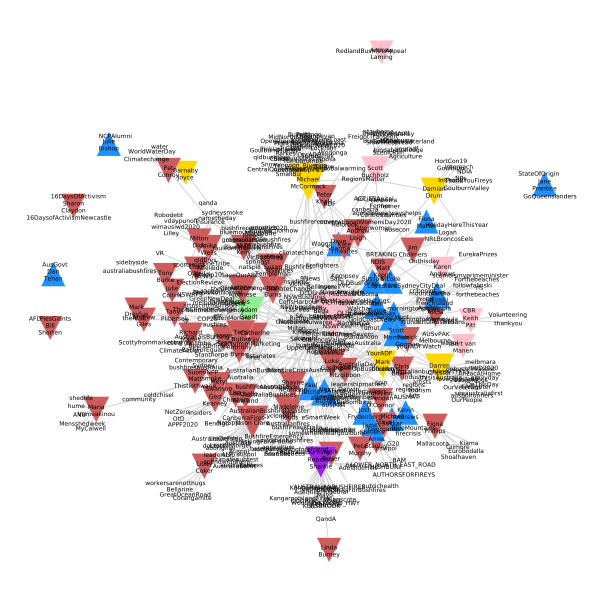

In [5]:
mp_hash_plot

In [6]:
#Get degree centralities
mp_hash_tn.degree

Adam Bandt            25
Alan Tudge             5
Alex Hawke            11
Alicia Payne           2
Andrew Giles           1
                      ..
waterbombers           1
wimausiwd2020          1
workersarenotthugs     1
yourADF                6
youradf                1
Length: 454, dtype: int64

In [7]:
#Create Party-Hashtag Network
party_hash_tn = create_network(hashtag_df, "party2", "hashtags")
party_hash_plot = plot_network(party_hash_tn)

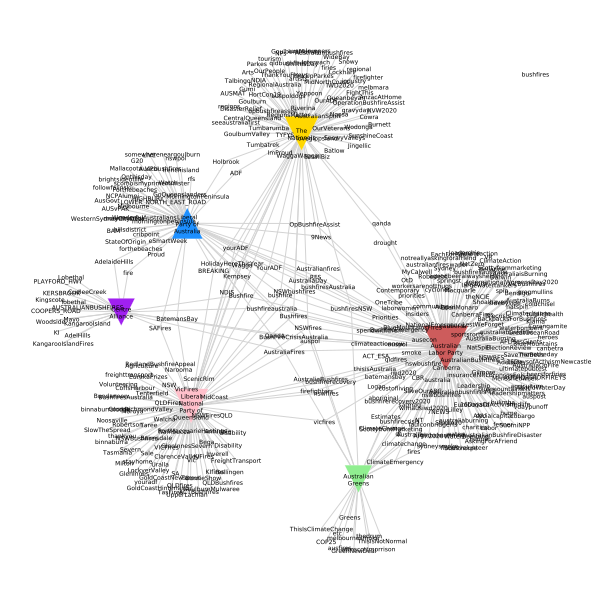

In [8]:
party_hash_plot

In [9]:
#Get degree centralities
party_hash_tn.degree

Australian Greens                        24
Australian Labor Party                  176
Centre Alliance                          22
Liberal National Party of Queensland     85
Liberal Party of Australia               55
                                       ... 
waterbombers                              1
wimausiwd2020                             1
workersarenotthugs                        1
yourADF                                   3
youradf                                   1
Length: 383, dtype: int64

In [10]:
#Create Party-Hashtag Network with hastags used more than once
party_hash_tn2 = create_network(hashtag_df, "party2", "top_hashtags")
party_hash_plot2 = plot_network(party_hash_tn2)

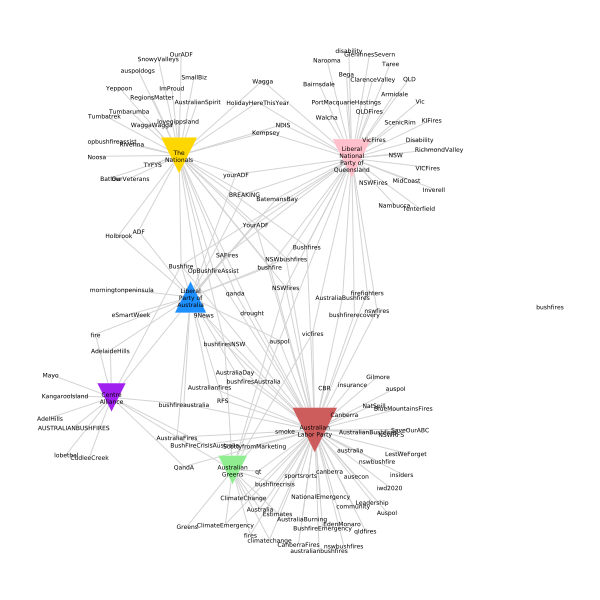

In [11]:
party_hash_plot2

In [12]:
#Create MP-cooccurance network. Display only documents
#Create Party-Hashtag Network
mp_cooccur_tn = create_network(hashtag_df, actor="name", doc_col="final_text", node_type = "doc")
mp_cooccur_plot = plot_network(mp_cooccur_tn)

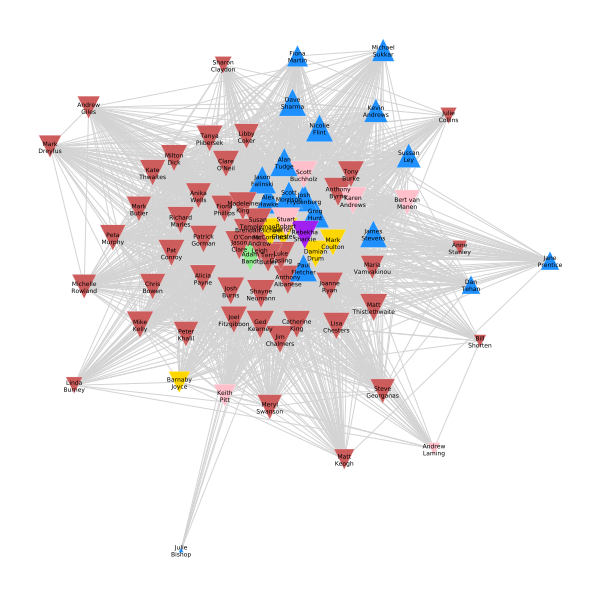

In [13]:
mp_cooccur_plot